In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

from correlated_noise_q_env_config import (
    q_env_config as gate_q_env_config,
    circuit_context,
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



 NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'unitary']
  Instructions with noise: ['custom_kron(rx,ident)_gate']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('custom_kron(rx,ident)_gate', (0, 1))] 

Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘
Circuit context
     ┌─────────────────────────────┐     
q_0: ┤0                            ├──■──
     │  custom_kron(rx,ident)_gate │┌─┴─┐
q_1: ┤1                            ├┤ X ├
     └─────────────────────────────┘└───┘


/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
# from gymnasium.spaces import Box

# # Adjust action space to noise being on x-component of second qubit
low = np.array([0., 0., 0., -0.5, 0., 0., 0.])
high = np.array([0., 0., 0., +0.5, 0., 0., 0.])

# new_action_space = Box(low=low, high=high, dtype=np.float32)
# gate_q_env_config.action_space = new_action_space

In [3]:
use_context = True
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        gate_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(gate_q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/venv_qiskit10/lib/python3.11/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/quantumenvironment.py:1079: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]


n_reps: 1
Checking reward to adjust C Factor...
fidelity access False
Fidelity stored: 0.9896701922386573
Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'YI', 'YZ'],
              coeffs=[ 1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j])
Finished Estimator job


In [4]:
rescaled_env.unwrapped.action_space

Box(-0.1, 0.1, (7,), float32)

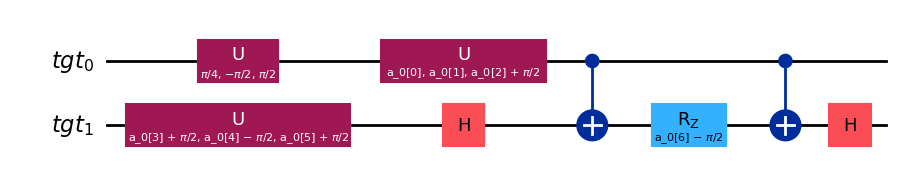

In [5]:
q_env.circuit_truncations[0].decompose().draw("mpl", style="iqp")

In [6]:
from helper_functions import load_from_yaml_file

agent_config = load_from_yaml_file('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/agent_config.yaml')

In [7]:
rescaled_env.unwrapped.backend

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>)

In [8]:
rescaled_env.unwrapped

QuantumEnvironment composed of 2 qubits, 
Defined target: gate (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]))
Physical qubits: [0, 1]
Backend: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['custom_kron(rx,ident)_gate']>),
Abstraction level: circuit,
Run options: N_shots (1), Sampling_Pauli_space (100), 
Batch size: 256, 
Number of target gates in circuit context: 1

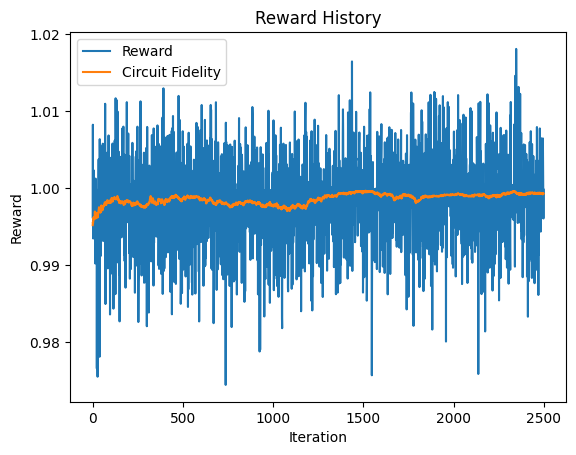

100%|██████████| 2500/2500 [39:52<00:00,  1.05it/s]


In [9]:
from ppo_unified import make_train_ppo

ppo_agent = make_train_ppo(agent_config, rescaled_env)

training_config = {
    'training_mode': 'Normal',
    'training_details': {
        'total_updates': 2_500,
        "target_fidelities": [0.99, 0.999, 0.9999],
        "lookback_window": 10,
        "anneal_learning_rate": True, # TODO: Anneal it down to predefined lowest value, i.e., 5e-5
        "std_actions_eps": 1e-2,
    },   
}

training_results = ppo_agent(
    training_config=training_config,
    plot_real_time=True,
    num_prints=50,
)

In [10]:
# from ppo import CustomPPO

# ppo_agent = CustomPPO(agent_config, rescaled_env)

# ppo_agent.train(
#     total_updates = 2500,
#     anneal_lr=True,
#     plot_real_time=True,
#     clear_history=True,
#     print_debug=False,
#     num_prints=1,
# )

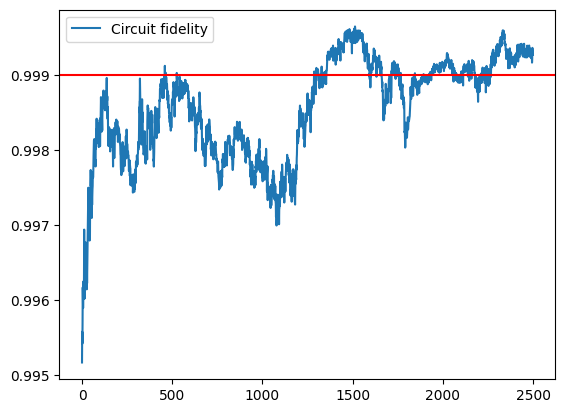

In [11]:
plt.plot(rescaled_env.unwrapped.circuit_fidelity_history, label='Circuit fidelity')
# Draw a horizontal line at the target fidelity
plt.axhline(y=0.999, color='r', linestyle='-')
plt.legend()

In [12]:
list(rescaled_env.unwrapped.__dict__.keys())

['_training_steps_per_gate',
 '_intermediate_rewards',
 'circuit_fidelity_history',
 '_trunc_index',
 '_inside_trunc_tracker',
 'training_config',
 'action_space',
 'n_shots',
 'n_reps',
 'sampling_Pauli_space',
 'c_factor',
 'training_with_cal',
 '_batch_size',
 '_parameters',
 '_tgt_instruction_counts',
 '_target_instruction_timings',
 '_reward_check_max',
 'circuit_gate_times',
 '_hardware_runtime',
 '_config_type',
 'target',
 'backend',
 'parametrized_circuit_func',
 '_func_args',
 'circuit_truncations',
 'baseline_truncations',
 'abstraction_level',
 '_estimator',
 'fidelity_checker',
 '_physical_target_qubits',
 'backend_info',
 '_physical_neighbor_qubits',
 '_physical_next_neighbor_qubits',
 '_param_values',
 'observation_space',
 '_seed',
 '_session_counts',
 '_step_tracker',
 '_total_shots',
 '_max_return',
 '_episode_ended',
 '_episode_tracker',
 '_benchmark_cycle',
 'action_history',
 'density_matrix_history',
 'reward_history',
 'qc_history',
 '_observables',
 '_pauli_shot

In [13]:
total_hardware_runtime = sum(rescaled_env.unwrapped._hardware_runtime)
print('Total hardware runtime:', round(total_hardware_runtime, 2), 's')

Total hardware runtime: 246.12 s
